# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import hw2code
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3, n_redundant=0, )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

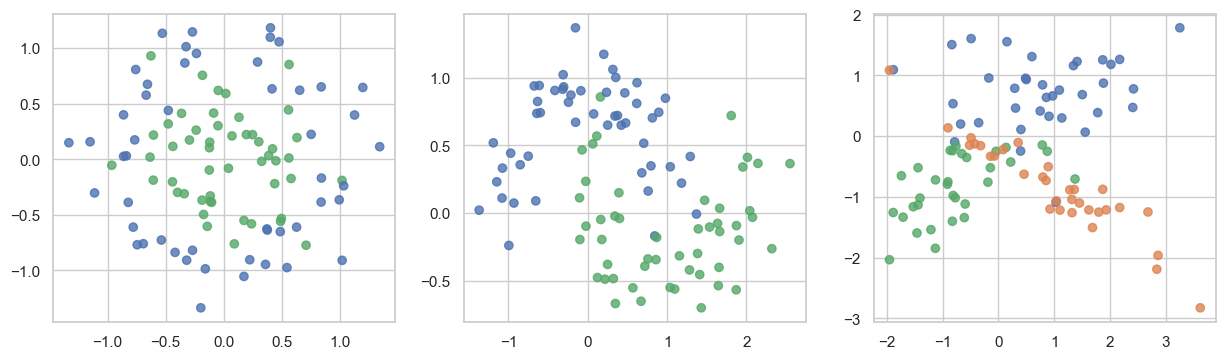

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

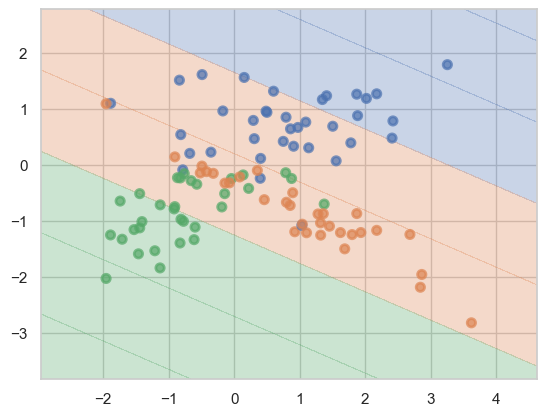

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

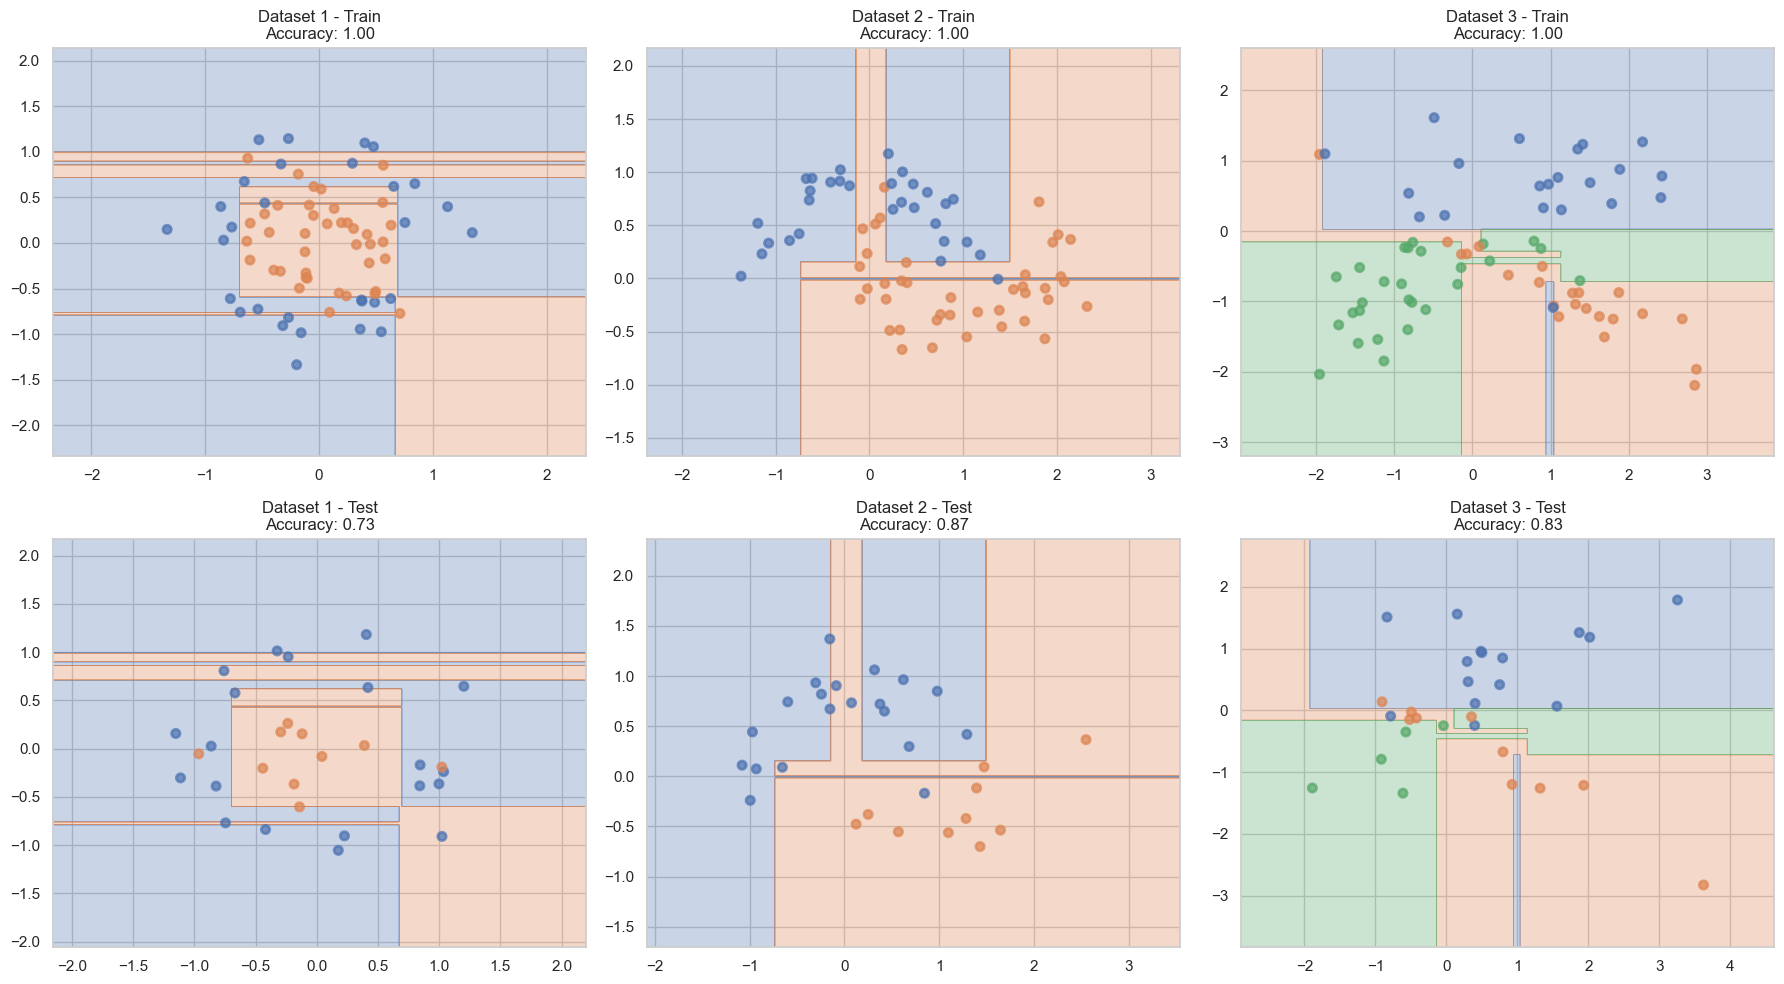

In [7]:
from sklearn.metrics import accuracy_score

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

def print_result(d_tree, x_train, x_test, y_tr, y_te, axe_0, axe_1, index):
    tr_acc = accuracy_score(y_tr, d_tree.predict(x_train))
    te_acc = accuracy_score(y_te, d_tree.predict(x_test))

    plt.sca(axe_0)
    plot_surface(d_tree, x_train, y_tr)
    plt.title(f'Dataset {index + 1} - Train\nAccuracy: {tr_acc:.2f}')

    plt.sca(axe_1)
    plot_surface(d_tree, x_test, y_te)
    plt.title(f'Dataset {index + 1} - Test\nAccuracy: {te_acc:.2f}')



for idx, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)

    print_result(tree, X_train, X_test, y_train, y_test, axes[0, idx], axes[1, idx], idx)

plt.tight_layout()
plt.show()

__Ответ:__ Да, деревья сильно переобучились.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

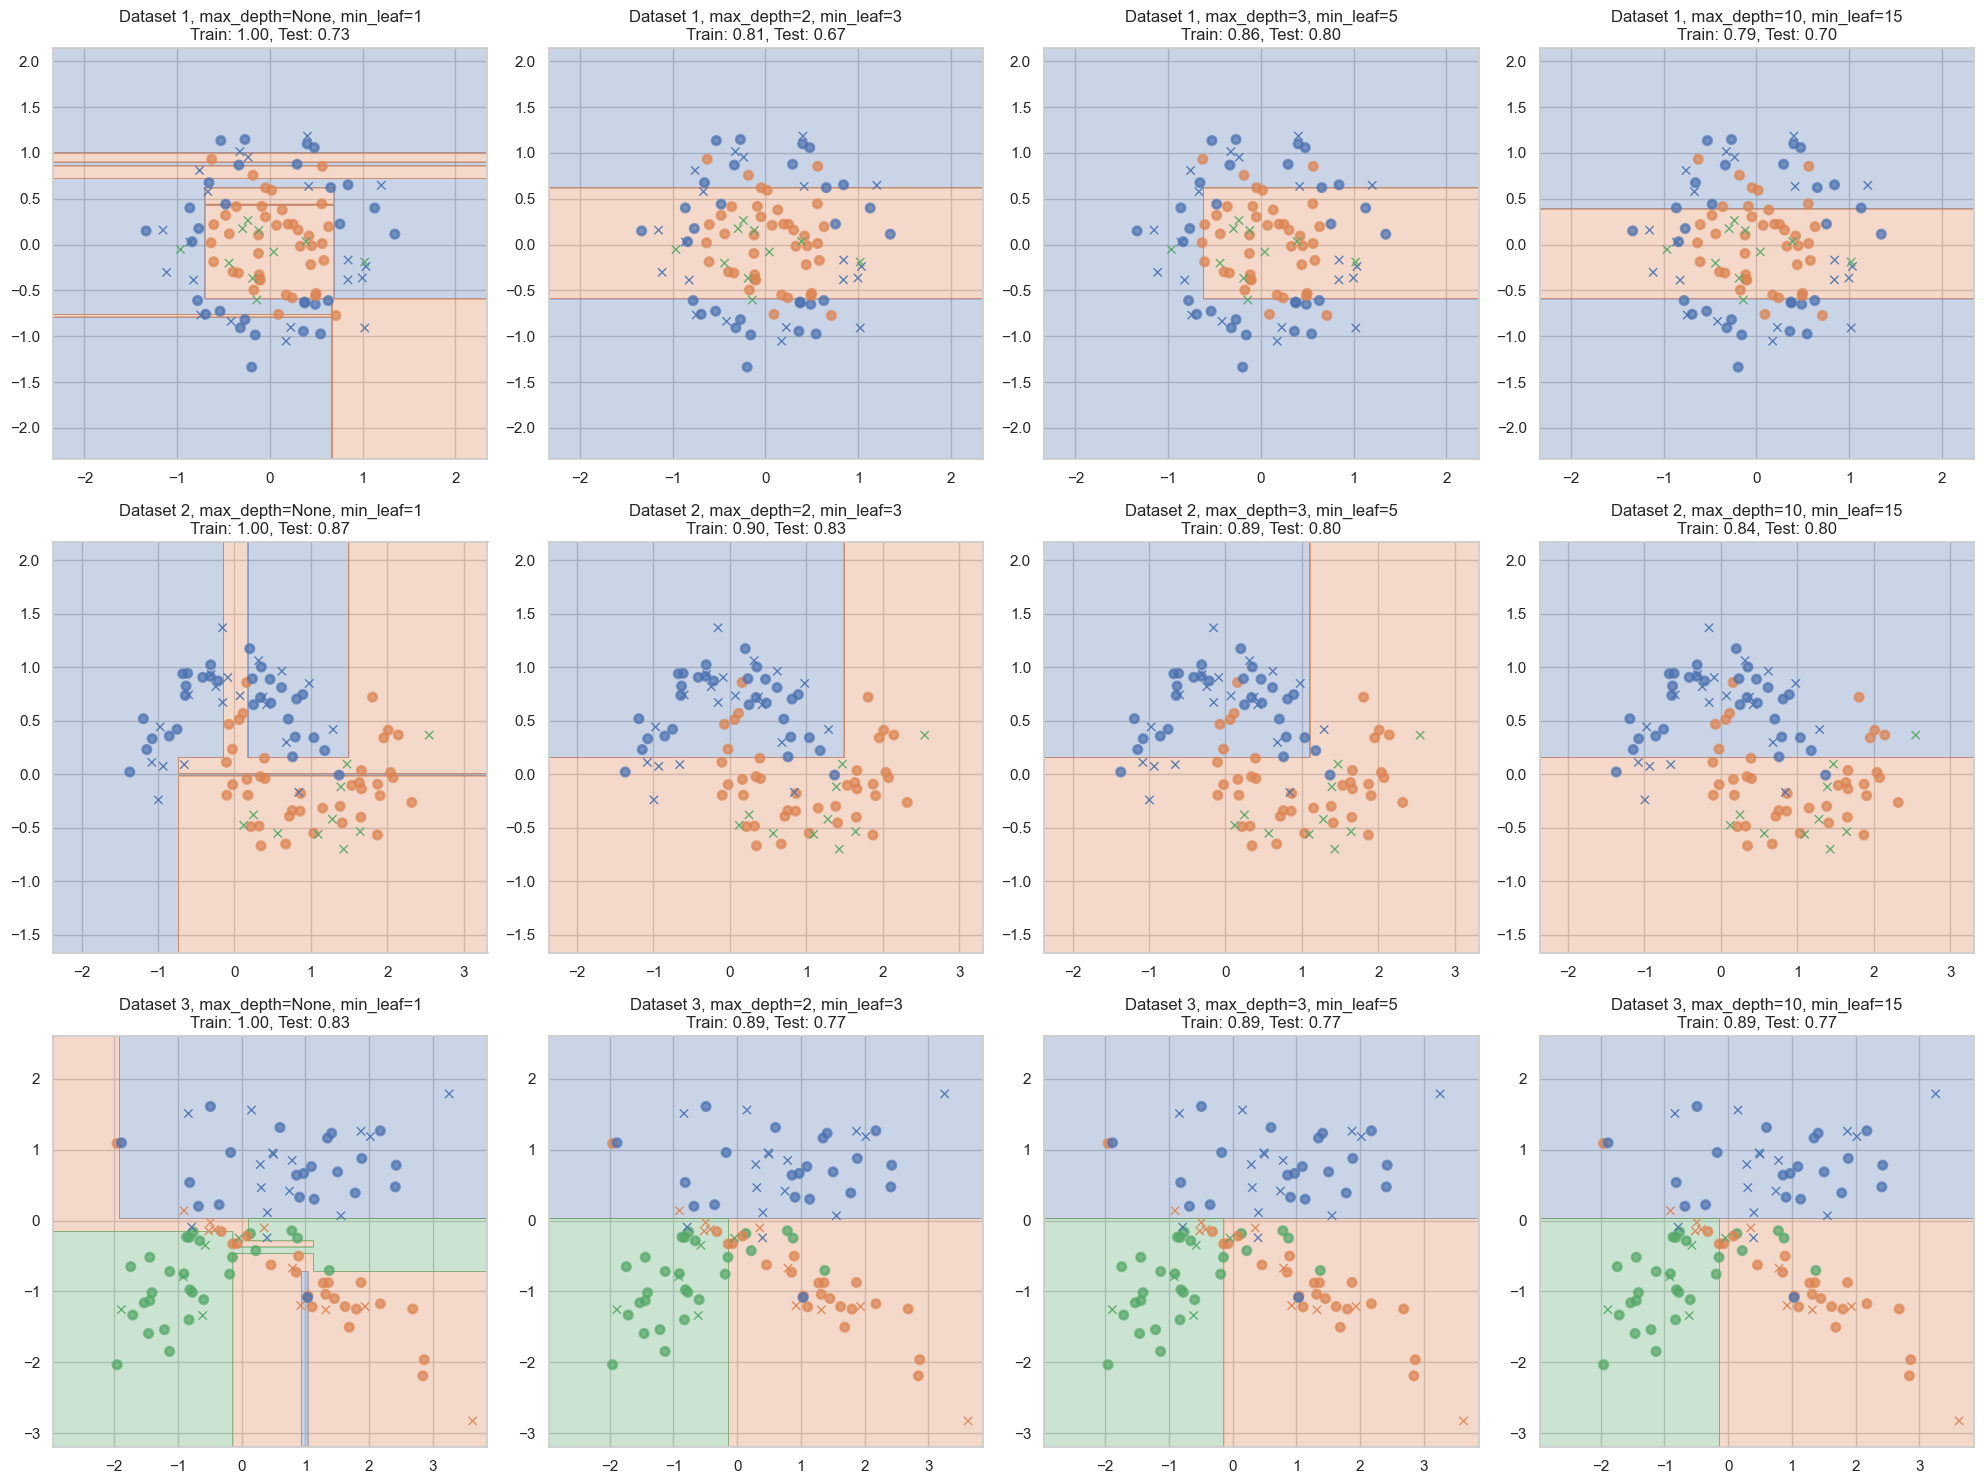

In [8]:
RANDOM_STATE = 42

max_depth_values = [None, 2, 3, 10]
min_samples_leaf_values = [1, 3, 5, 15]

fig, axes = plt.subplots(len(datasets), len(max_depth_values), figsize=(20, 15))

for dataset_idx, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    for param_idx, max_depth in enumerate(max_depth_values):
        tree = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf_values[param_idx],
            random_state=RANDOM_STATE
        )
        tree.fit(X_train, y_train)

        train_acc = accuracy_score(y_train, tree.predict(X_train))
        test_acc = accuracy_score(y_test, tree.predict(X_test))

        plt.sca(axes[dataset_idx, param_idx])
        plot_surface(tree, X_train, y_train)

        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap, alpha=0.9,
                   edgecolors=np.array(palette)[y_test], linewidths=1, marker='x')

        plt.title(f'Dataset {dataset_idx+1}, max_depth={max_depth}, min_leaf={min_samples_leaf_values[param_idx]}\n'
                  f'Train: {train_acc:.2f}, Test: {test_acc:.2f}')

plt.tight_layout()
plt.show()

__Ответ:__ Разделяющая поверхность для всех датасетов без регуляции очень сложная, учитывающая выбросы. С добавлением ограничивающих параметров поверхность стала менее зубчатая. Обобщающая способность для первых двух датасетов улучшилась, а для последнего стала хуже. Это связано с тем, что последний дата сет содержит более сложную структуру и грубая регуляция приводит к недообучению.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

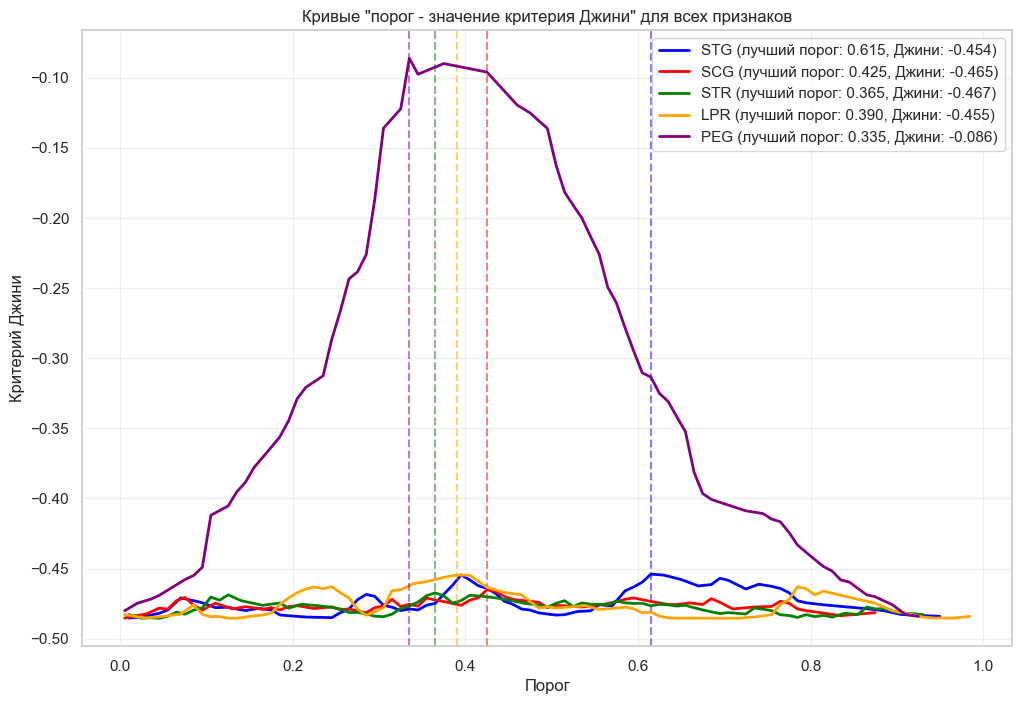

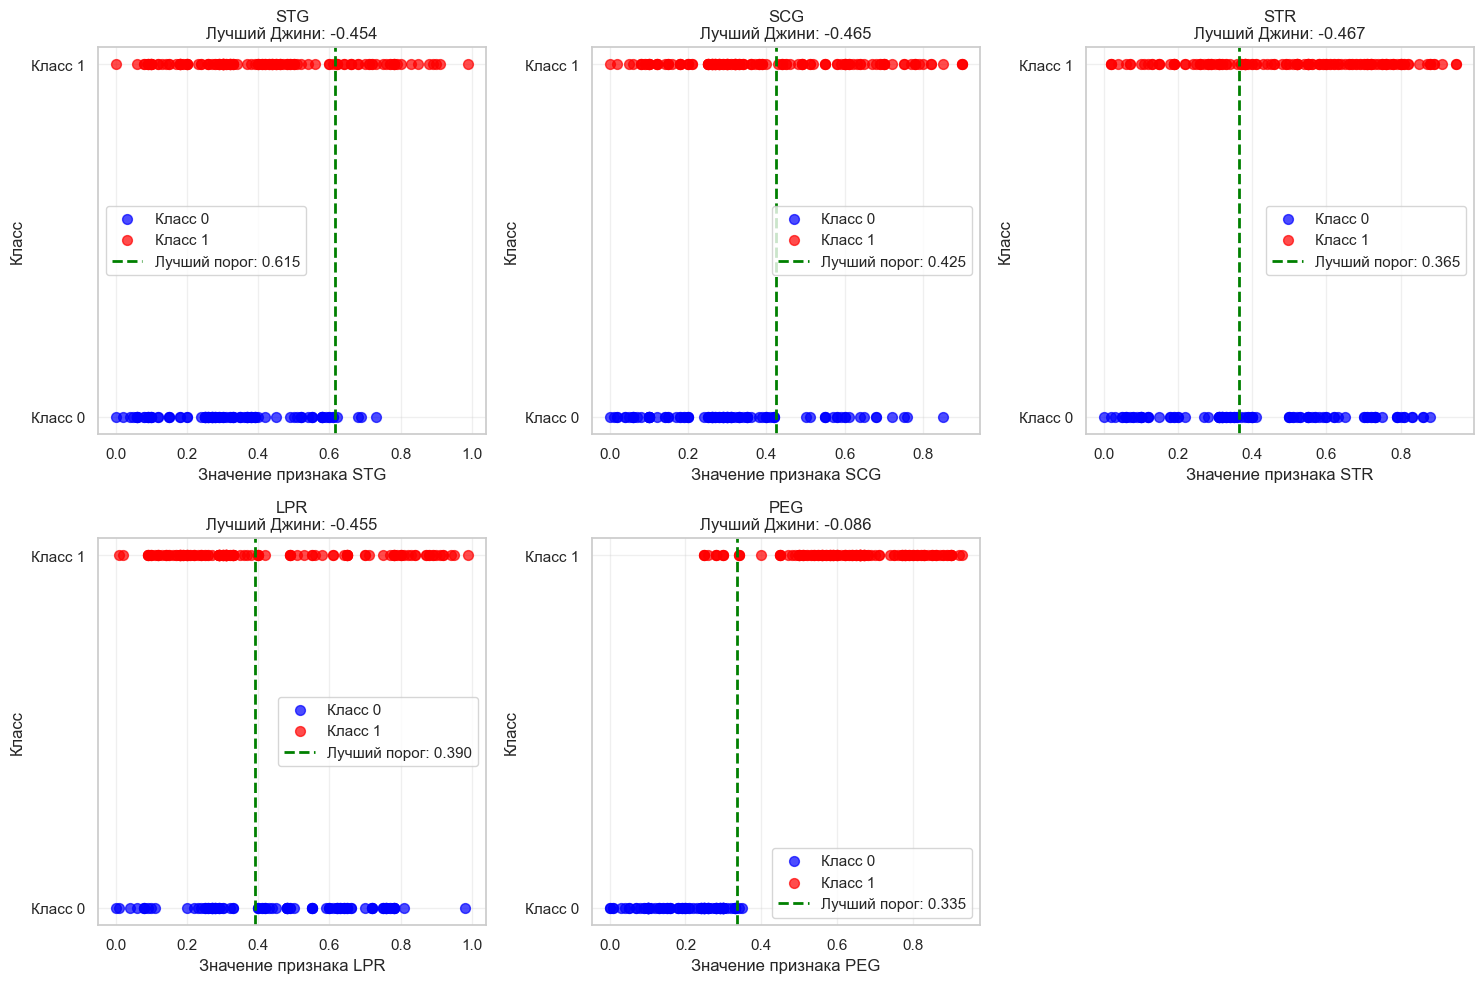

In [9]:
df = pd.read_csv('datasets\students.csv')

X = df.iloc[:, :5]
y = df.iloc[:, 5]

fig, axe = plt.subplots(figsize=(12, 8))
fig2, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, feature_name in enumerate(X.columns):
    feature_vector = X[feature_name].values
    target_vector = y.values

    thresholds, ginis, threshold_best, gini_best = hw2code.find_best_split(feature_vector, target_vector)

    # Кривая Джини
    if len(thresholds) > 0:
        axe.plot(thresholds, ginis, color=colors[i], linewidth=2,
                 label=f'{feature_name} (лучший порог: {threshold_best:.3f}, Джини: {gini_best:.3f})')
        axe.axvline(x=threshold_best, color=colors[i], linestyle='--', alpha=0.5)
    # scatter-графики
    ax = axes[i]
    class_0 = feature_vector[target_vector == 0]
    class_1 = feature_vector[target_vector == 1]

    ax.scatter(class_0, np.zeros_like(class_0), alpha=0.7,
               color='blue', label='Класс 0', s=50)
    ax.scatter(class_1, np.ones_like(class_1), alpha=0.7,
               color='red', label='Класс 1', s=50)

    if threshold_best is not None:
        ax.axvline(x=threshold_best, color='green', linestyle='--',
                   linewidth=2, label=f'Лучший порог: {threshold_best:.3f}')

    ax.set_xlabel(f'Значение признака {feature_name}')
    ax.set_ylabel('Класс')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Класс 0', 'Класс 1'])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_title(f'{feature_name}\nЛучший Джини: {gini_best:.3f}' if gini_best else f'{feature_name}')

axe.set_xlabel('Порог')
axe.set_ylabel('Критерий Джини')
axe.set_title('Кривые "порог - значение критерия Джини" для всех признаков')
axe.legend()
axe.grid(True, alpha=0.3)

for j in range(len(X.columns), 6):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Делить нужно по признаку PEG, так как он имеет наибольшее значение критерия Джини (-0.086), что означает наилучшее разделение. Этот результат согласуется с визуализацией. На scatter-графике PEG видно, что классы почти идеально разделяются порогом ~0.335: слева — почти только Класс 0, справа — почти только Класс 1. Кривая "хороших" признаков имеет резкий и высокий пик (максимальное значение Джини близко к нулю или слабо отрицательное), что указывает на возможность почти идеального разделения в
отличие кривой "плохих" признаков. Она почти плоская и сильно отрицательная (близка к -0.5), что говорит о полном смешении классов и невозможности их разделения по этому признаку.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [10]:
from sklearn.preprocessing import LabelEncoder
from hw2code import DecisionTree

column_names = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
                'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color',
                'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

data = pd.read_csv('datasets/agaricus-lepiota.data', names=column_names)

for column in data.columns:
    if data[column].isin(['?']).any():
        most_common = data[data[column] != '?'][column].mode()[0]
        data[column] = data[column].replace('?', most_common)

le = LabelEncoder()
data['class'] = le.fit_transform(data['class'])

X = data.drop('class', axis=1)
y = data['class'].values

feature_types = ["categorical"] * X.shape[1]
X_encoded = X.apply(LabelEncoder().fit_transform).values

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.5, random_state=42)

tree = DecisionTree(feature_types=feature_types, max_depth=5)
tree.fit(X_train, y_train)

accuracy = accuracy_score(y_test, tree.predict(X_test))
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.4867


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

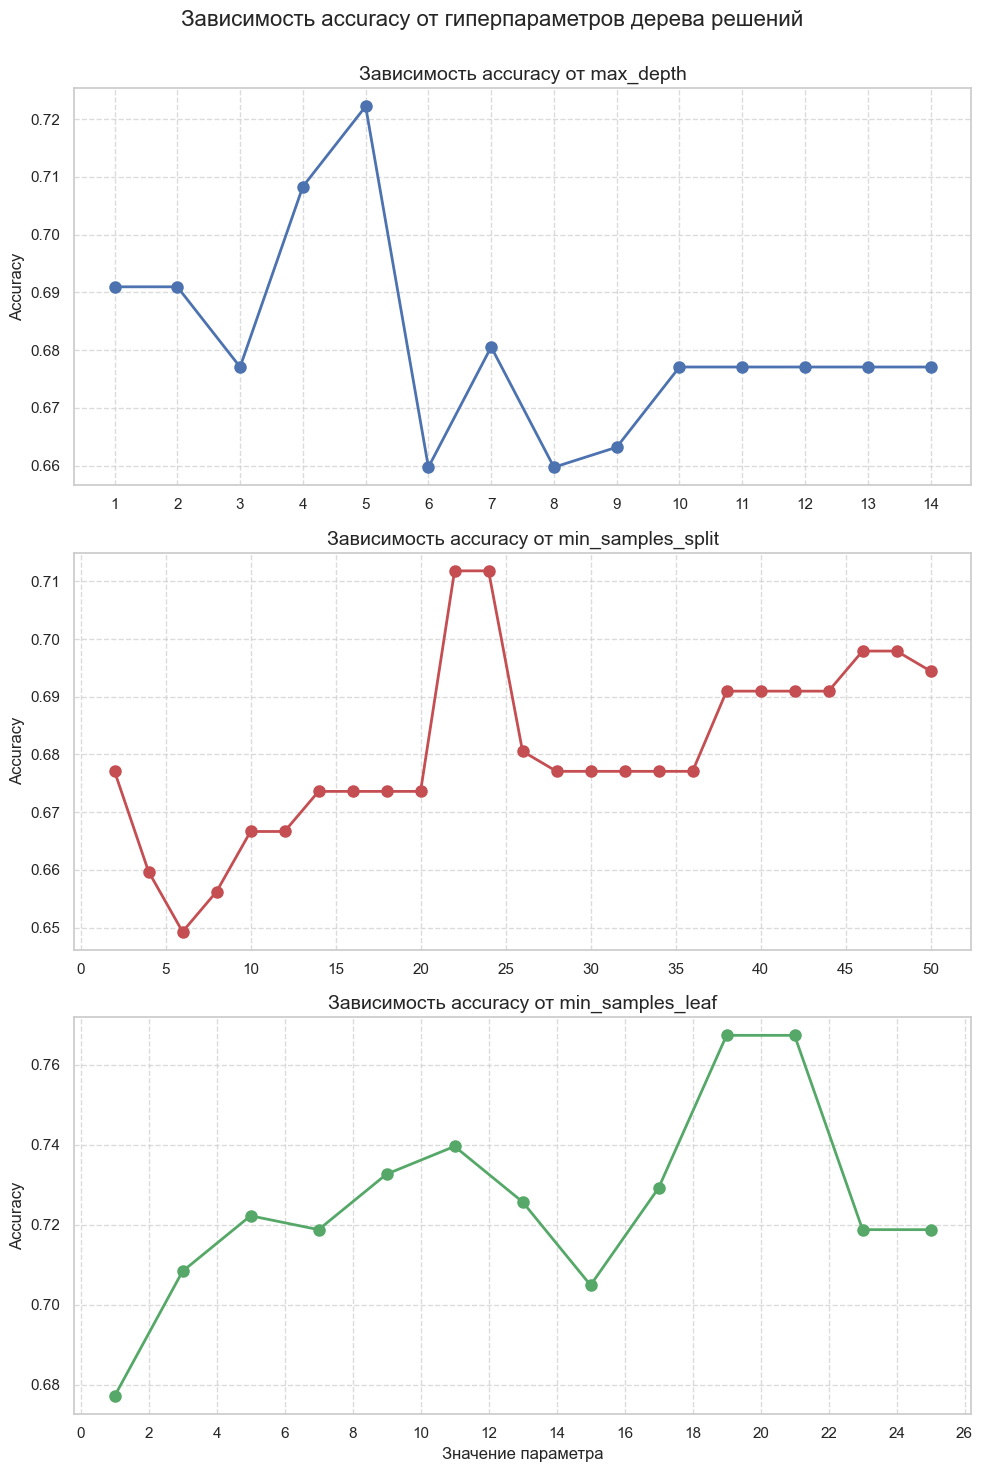

In [11]:
column_names = ['top-left-square', 'top-middle-square', 'top-right-square',
                'middle-left-square', 'middle-middle-square', 'middle-right-square',
                'bottom-left-square', 'bottom-middle-square', 'bottom-right-square',
                'class']
data = pd.read_csv("datasets/tic-tac-toe-endgame.csv", header=None, names=column_names)

X = data.drop('class', axis=1)
y = data['class']

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

X_encoded = X.apply(LabelEncoder().fit_transform)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded.values, y_encoded, test_size=0.3, random_state=42
)

feature_types = ["categorical"] * X_encoded.shape[1]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=False)
fig.suptitle('Зависимость accuracy от гиперпараметров дерева решений', fontsize=16)

max_depths = range(1, 15)
accuracies_depth = []

for depth in max_depths:
    tree = DecisionTree(
        feature_types=feature_types,
        max_depth=depth,
        min_samples_split=2,
        min_samples_leaf=1
    )
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    accuracies_depth.append(accuracy_score(y_test, y_pred))

ax1.plot(max_depths, accuracies_depth, 'bo-', linewidth=2, markersize=8)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Зависимость accuracy от max_depth', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xticks(max_depths)



min_samples_splits = range(2, 51, 2)
accuracies_split = []

for split in min_samples_splits:
    tree = DecisionTree(
        feature_types=feature_types,
        max_depth=10,
        min_samples_split=split,
        min_samples_leaf=1
    )
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    accuracies_split.append(accuracy_score(y_test, y_pred))

ax2.plot(min_samples_splits, accuracies_split, 'ro-', linewidth=2, markersize=8)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Зависимость accuracy от min_samples_split', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xticks(range(0, 52, 5))



min_samples_leafs = range(1, 26, 2)
accuracies_leaf = []

for leaf in min_samples_leafs:
    tree = DecisionTree(
        feature_types=feature_types,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=leaf
    )
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    accuracies_leaf.append(accuracy_score(y_test, y_pred))

ax3.plot(min_samples_leafs, accuracies_leaf, 'go-', linewidth=2, markersize=8)
ax3.set_xlabel('Значение параметра', fontsize=12)
ax3.set_ylabel('Accuracy', fontsize=12)
ax3.set_title('Зависимость accuracy от min_samples_leaf', fontsize=14)
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.set_xticks(range(0, 27, 2))


plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.98))
plt.show()

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

Processing dataset: mushrooms
Results for mushrooms:
DT_real: 0.9993
DT_categorical: 0.4822
DT_real_oh: 1.0000
DT_sklearn: 0.9567
--------------------------------------------------
Processing dataset: tic-tac-toe
Results for tic-tac-toe:
DT_real: 0.4981
DT_categorical: 0.5535
DT_real_oh: 0.5950
DT_sklearn: 0.7635
--------------------------------------------------
Processing dataset: cars
Results for cars:
DT_real: 0.9426
DT_categorical: 0.8182
DT_real_oh: 0.9235
DT_sklearn: 0.9427
--------------------------------------------------
Processing dataset: nursery
Results for nursery:
DT_real: 0.9997
DT_categorical: 0.9998
DT_real_oh: 0.9998
DT_sklearn: 0.9997
--------------------------------------------------

Final Results DataFrame:
              DT_real  DT_categorical  DT_real_oh  DT_sklearn
mushrooms    0.999261        0.482209    1.000000    0.956689
tic-tac-toe  0.498125        0.553542    0.595011    0.763476
cars         0.942647        0.818211    0.923498    0.942707
nursery     

<Figure size 1200x600 with 0 Axes>

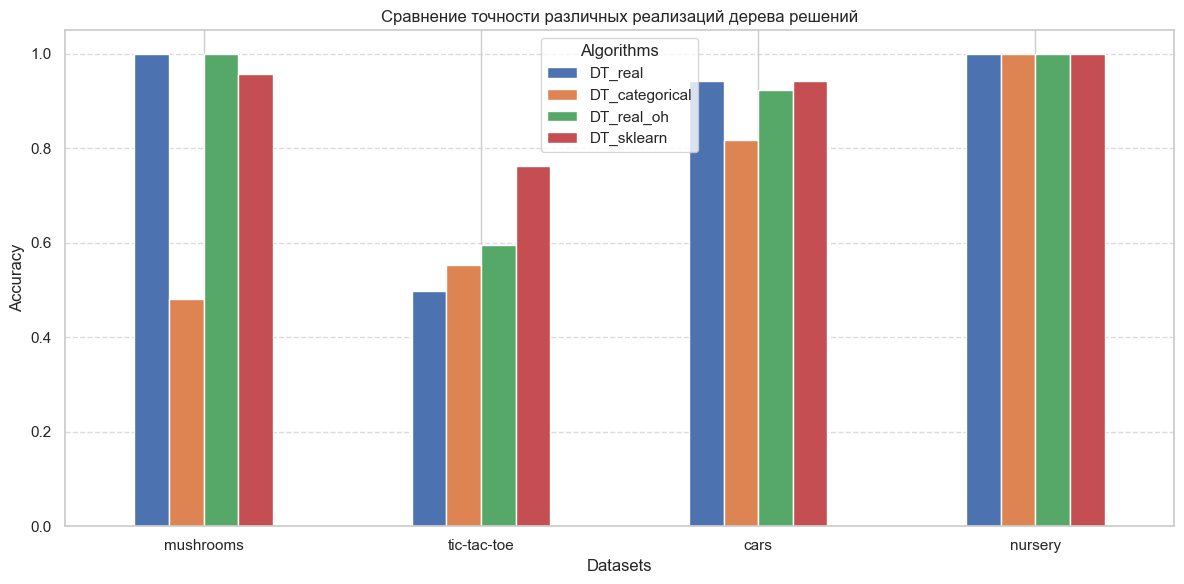

In [14]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from hw2code import DecisionTreeWrapper

mushroom_url = "datasets/agaricus-lepiota.data"
mushroom_column_names = ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
                         'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
                         'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
                         'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color',
                         'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
mushrooms = pd.read_csv(mushroom_url, header=None, names=mushroom_column_names)


tic_tac_toe_url = "datasets/tic-tac-toe-endgame.csv"
tic_tac_toe_column_names = ['top-left-square', 'top-middle-square', 'top-right-square',
                            'middle-left-square', 'middle-middle-square', 'middle-right-square',
                            'bottom-left-square', 'bottom-middle-square', 'bottom-right-square',
                            'class']
tic_tac_toe = pd.read_csv(tic_tac_toe_url, header=None, names=tic_tac_toe_column_names)

cars_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
cars_column_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
cars = pd.read_csv(cars_url, header=None, names=cars_column_names)

nursery_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data"
nursery_column_names = ['parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'class']
nursery = pd.read_csv(nursery_url, header=None, names=nursery_column_names)

for column in mushrooms.columns:
    if mushrooms[column].isin(['?']).any():
        most_common = mushrooms[mushrooms[column] != '?'][column].mode()[0]
        mushrooms[column] = mushrooms[column].replace('?', most_common)

mushrooms_y = mushrooms['class'].values
mushrooms_y_encoded = np.where(mushrooms_y == 'e', 0, 1)
mushrooms_X = mushrooms.drop('class', axis=1)

tic_tac_toe_y = tic_tac_toe['class'].values
tic_tac_toe_y_encoded = np.where(tic_tac_toe_y == 'positive', 1, 0)
tic_tac_toe_X = tic_tac_toe.drop('class', axis=1)

cars_y = cars['class'].values
cars_y_encoded = np.where((cars_y == 'unacc') | (cars_y == 'acc'), 0, 1)
cars_X = cars.drop('class', axis=1)

nursery_y = nursery['class'].values
nursery_y_encoded = np.where((nursery_y == 'not_recom') | (nursery_y == 'recommend'), 0, 1)
nursery_X = nursery.drop('class', axis=1)

def encode_features(X):
    X_encoded = X.copy()
    for column in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[column] = le.fit_transform(X_encoded[column])
    return X_encoded.values

mushrooms_X_encoded = encode_features(mushrooms_X)
tic_tac_toe_X_encoded = encode_features(tic_tac_toe_X)
cars_X_encoded = encode_features(cars_X)
nursery_X_encoded = encode_features(nursery_X)

def one_hot_encode(X):
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    return encoder.fit_transform(X)

mushrooms_X_oh = one_hot_encode(mushrooms_X_encoded)
tic_tac_toe_X_oh = one_hot_encode(tic_tac_toe_X_encoded)
cars_X_oh = one_hot_encode(cars_X_encoded)
nursery_X_oh = one_hot_encode(nursery_X_encoded)

datasets = [
    ('mushrooms', mushrooms_X_encoded, mushrooms_y_encoded, mushrooms_X_oh),
    ('tic-tac-toe', tic_tac_toe_X_encoded, tic_tac_toe_y_encoded, tic_tac_toe_X_oh),
    ('cars', cars_X_encoded, cars_y_encoded, cars_X_oh),
    ('nursery', nursery_X_encoded, nursery_y_encoded, nursery_X_oh)
]


results = {dataset_name: {} for dataset_name, _, _, _ in datasets}

scorer = make_scorer(accuracy_score)

for dataset_name, X, y, X_oh in datasets:
    print(f"Processing dataset: {dataset_name}")

    # DT_real - все признаки вещественные
    feature_types_real = ["real"] * X.shape[1]
    model_real = DecisionTreeWrapper(feature_types=feature_types_real)
    scores_real = cross_val_score(model_real, X, y, cv=10, scoring=scorer, n_jobs=-1)
    results[dataset_name]['DT_real'] = np.mean(scores_real)

    # DT_categorical - все признаки категориальные
    feature_types_cat = ["categorical"] * X.shape[1]
    model_cat = DecisionTreeWrapper(feature_types=feature_types_cat)
    scores_cat = cross_val_score(model_cat, X, y, cv=10, scoring=scorer, n_jobs=-1)
    results[dataset_name]['DT_categorical'] = np.mean(scores_cat)

    # DT_real_oh - все признаки вещественные + one-hot encoding
    feature_types_oh = ["real"] * X_oh.shape[1]
    model_oh = DecisionTreeWrapper(feature_types=feature_types_oh)
    scores_oh = cross_val_score(model_oh, X_oh, y, cv=10, scoring=scorer, n_jobs=-1)
    results[dataset_name]['DT_real_oh'] = np.mean(scores_oh)

    # DT_sklearn - дерево из sklearn
    model_sklearn = DecisionTreeClassifier(random_state=42)
    scores_sklearn = cross_val_score(model_sklearn, X, y, cv=10, scoring=scorer, n_jobs=-1)
    results[dataset_name]['DT_sklearn'] = np.mean(scores_sklearn)

    print(f"Results for {dataset_name}:")
    print(f"DT_real: {results[dataset_name]['DT_real']:.4f}")
    print(f"DT_categorical: {results[dataset_name]['DT_categorical']:.4f}")
    print(f"DT_real_oh: {results[dataset_name]['DT_real_oh']:.4f}")
    print(f"DT_sklearn: {results[dataset_name]['DT_sklearn']:.4f}")
    print("-" * 50)

# Создание DataFrame с результатами
results_df = pd.DataFrame(results).T
results_df.columns = ['DT_real', 'DT_categorical', 'DT_real_oh', 'DT_sklearn']
print("\nFinal Results DataFrame:")
print(results_df)

# Визуализация результатов
plt.figure(figsize=(12, 6))
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Сравнение точности различных реализаций дерева решений')
plt.ylabel('Accuracy')
plt.xlabel('Datasets')
plt.xticks(rotation=0)
plt.legend(title='Algorithms')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** Ранжирование алгоритмов существенно различается для разных наборов данных, что свидетельствует об отсутствии универсального лучшего алгоритма. Для Mushrooms DT_real_oh показывает наилучший результат (1.0), поскольку one-hot encoding эффективно выделяет ключевой бинарный признак "odor", критически важный для классификации грибов. Для Tic-tac-toe DT_sklearn значительно превосходит другие методы (0.7635), так как оптимально настроен для работы с категориальными признаками без искусственного упорядочивания. Для Cars DT_sklearn и DT_real работают почти одинаково хорошо (около 0.942), используя естественную иерархическую структуру данных. Для Nursery все алгоритмы показывают почти идеальные результаты (>= 0.9997), поскольку данные имеют простую структуру.
Компонента случайности присутствует в результате DT_real для tic-tac-toe (0.4981), близкий к случайному угадыванию и в неожиданно высоких результатах простой реализации на mushrooms
Для улучшения можно добавить адаптивную обработку признаков и настройку гиперпараметров

Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [13]:
print("😮‍💨🫠🙃")

😮‍💨🫠🙃
